# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Lines Finding on the Road** 

##  






## Import Packages

In [39]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
%matplotlib inline

## Lane Class Definition

In [40]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Function Definitions

In [42]:
# Helper functions project 1 #########################################################################
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
######################################################################################################


# Color based threshold functions ####################################################################
######################################################################################################


# Gradient based threshold functions #################################################################
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Absolute values and normalizing
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply thresholds
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[np.logical_and(scaled_sobel >= thresh[0], scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    xsobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Absolute values and normalizing
    magn_sobel = np.sqrt(np.square(xsobel) + np.square(ysobel))
    scaled_magn = np.uint8(255*magn_sobel/np.max(magn_sobel))
    # Apply thresholds
    mag_binary = np.zeros_like(magn_sobel)
    mag_binary[np.logical_and(scaled_magn >= mag_thresh[0], scaled_magn <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    xsobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_xsobel = np.absolute(xsobel)
    abs_ysobel = np.absolute(ysobel)
    # Gradient direction and normalization
    direct_sobel = np.arctan2(abs_ysobel, abs_xsobel)
    # Apply thresholds
    dir_binary = np.zeros_like(direct_sobel)
    dir_binary[np.logical_and(direct_sobel >= thresh[0], direct_sobel <= thresh[1])] = 1
    return dir_binary
######################################################################################################

# Lane Finding Pipeline

## 0.) Camera calibration

Camera calibartion is not actually an iterative step of the lane line finding pipeline but rather a preprocessing step. The calibration matrix and distortion coefficients are calculated based on the chessboard calibration data (i.e. images) once. Afterwards they are used as static values (data structures) in order to undistort input images when they are passed into the pipeline. The theoretical background behind camera calibration is to learn a camera model which transforms 3D real world points into the 2D camera space. If this transformation model (including distrubances) is known, one can apply the revere transformation in order to undistort the corresponding camera images, i.e. to filter out the distortions. Finding the camera model is done by solving an optimization problem. One aims to find the camera parameters which describes the transformation between known 3D world points and 2D images points best.      

In [43]:
# Prepare object points and create data structure to store both object points and input points
# Object points represent the 3D point in the world cos
# Input points represent the 2D point in the image cos
# --> 1.) Define number of corners in x and y direction
nx = 9
ny = 6
# --> 2.) Manually define actual corner positions in the real world cos (Assumption: z=0 --> flat plane)
#         The structure is supposed to be like (x1, y1, z1) in an array format, i.e. [ [1, 1, 0], [2, 1, 0], ... ]
objp = np.zeros(((nx)*(ny),3), np.float32)
objp[:,:2] = np.mgrid[1:nx+1,1:ny+1].T.reshape(-1,2)
# --> 3.) Define the image shape and (empty) lists for both object points and image points
imageShape = mpimg.imread("camera_cal/calibration1.jpg").shape[1::-1]
objPoints = []
imgPoints = []

# Iterate over calibration images, search for corners and concatenate respective image points"
calImgsList = os.listdir("camera_cal/")
for imgName in calImgsList:
    calImg = mpimg.imread("camera_cal/" + imgName)
    gray = cv2.cvtColor(calImg, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True: 
        objPoints.append(objp)
        imgPoints.append(corners)

# Calibrate the image points against the object points, i.e. calculate the camera model        
# --> The camera matrix and distortion coefficients can be used later in the pipeline 
#     to undistort the camera image input(s)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imageShape, None, None)

## 1.) Distortion Correction
Due to the fact that cameras adding some distortion, one has to componsate for these in order to use the actual (i.e. undistorted) image information within the pipeline. That´s why the first step in the lane line finding pipeline is to apply an undistortion filter utilizing the camera model (i.e. camera matrix) and the distortion coefficients. Both the camera model and the distortion coefficients has been acquired in the (offline) calibration step.  

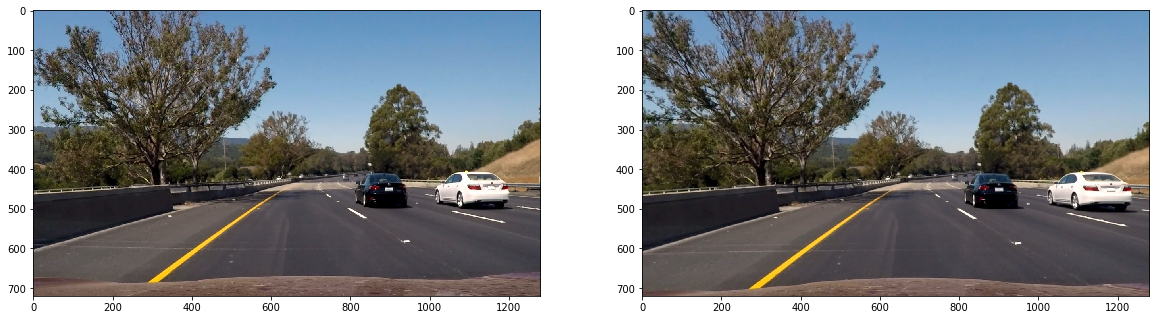

In [5]:
# Undistort test image
testImgIndex = 7
testImgList = os.listdir("test_images/") 
testImg = mpimg.imread("test_images/" + testImgList[testImgIndex])
testImgUndistort = cv2.undistort(testImg, mtx, dist, None, mtx)

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testImg)
ax2.imshow(testImgUndistort); 

## 2.) Color thresholds
The next step in the pipeline is to use the undistroted image as input and to apply color thresholds which describe yellow and white lanes. Due to lighting and brightnes deviations it´s unfortunate to use RGB thresholding. A more robust solution is to utilize the S (saturation) channel in the HLS color space. The thresholds are manually adapted on the test images.    

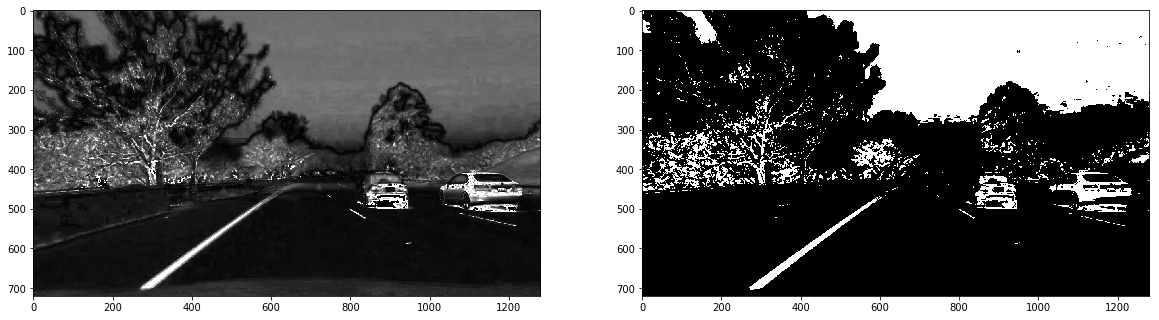

In [15]:
# Apply color threshold on the S channel in the HLS color space
# --> 1.) Transformation of the undistorted test image to the HLS space and separate the S channel 
hls = cv2.cvtColor(testImgUndistort, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]
# --> 2.) Define the color threshold and apply the threshold to the S-channel.
#         Results, i.e. whether a certain pixel is within (true) or out of (false) the threhold, are stored in a binary map
colorThresh = (100, 255)
colorBinary = np.zeros_like(S)
colorBinary[(S > colorThresh[0]) & (S <= colorThresh[1])] = 1

# Plot the binary map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(S, cmap="gray")
ax2.imshow(colorBinary, cmap="gray"); 

## 3.) Gradient based thresholds
Besided applying color thresholds, also gradient based thresholds are promising to identify lanes in the input images. Rather than utilizing knowledge about common colors of lanes, one uses gradient based information in order to laverage the contrast which lane markings have compared to the road. Also one can use the direction in which the corresponding color changes occurs. Like in the color threshold case, the parameters are manually adapted on the test images.    

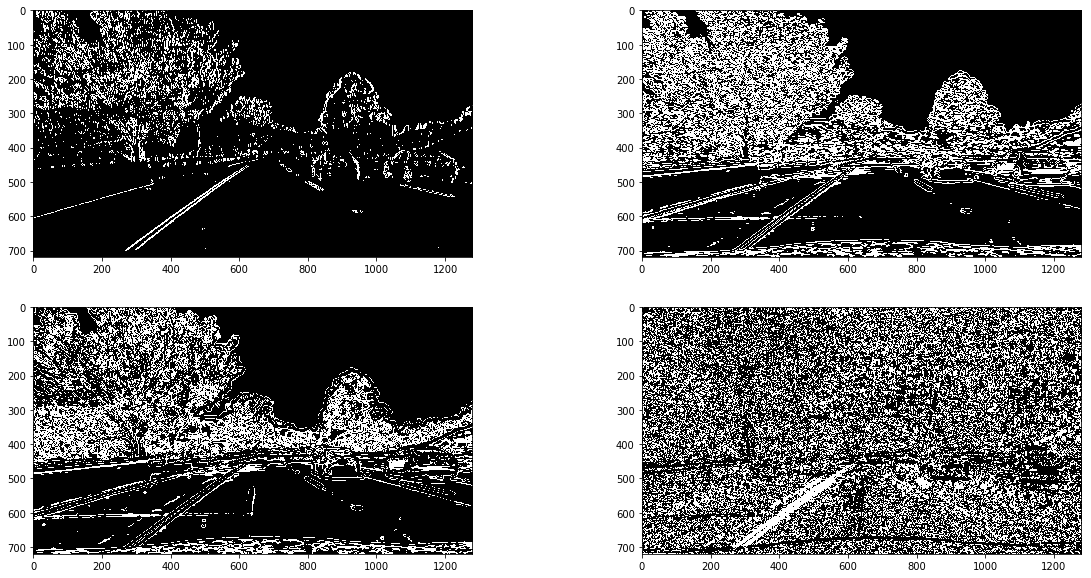

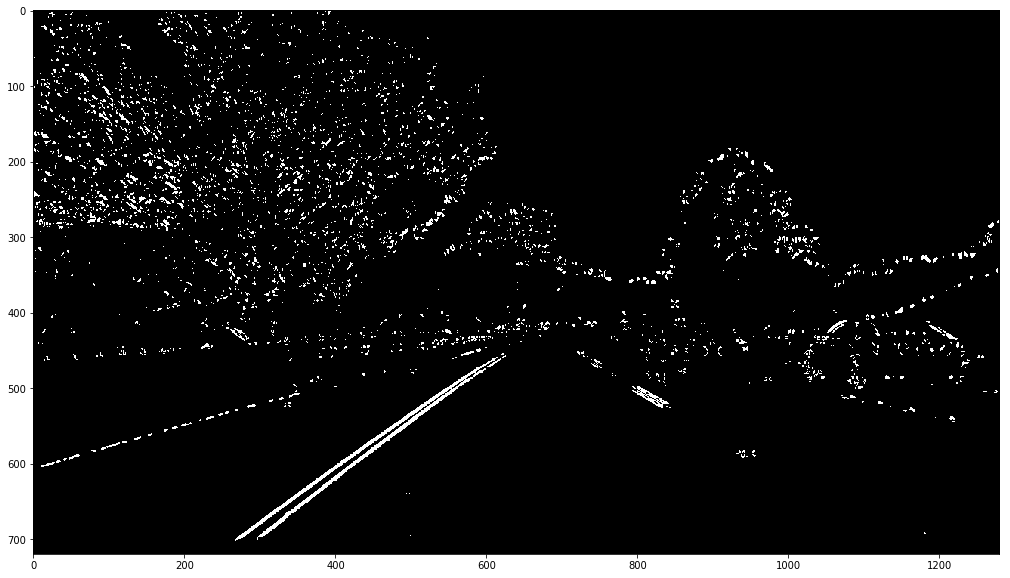

In [35]:
# Apply gradient based thresholds and combine them in order to create a unique gradient based output
# --> 1.) Gradient magnitude
magBinary = mag_thresh(testImgUndistort, sobel_kernel=19, mag_thresh=(10, 30))
# --> 2.) Gradient in x and y direction
xGradBinary = abs_sobel_thresh(testImgUndistort, orient='x', sobel_kernel=11, thresh=(30, 100))
yGradBinary = abs_sobel_thresh(testImgUndistort, orient='y', sobel_kernel=19, thresh=(10, 50))
# --> 3.) Gradient direction
dirBinary = dir_threshold(testImgUndistort, sobel_kernel=17, thresh=(0.7, 1.3))
# --> 4.) Combine the above three findings into one single gradient based output
gradientCombBinary = np.zeros_like(magBinary)
gradientCombBinary[(xGradBinary==1) & (dirBinary==1)] = 1

# Plot the binary maps
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0,0].imshow(xGradBinary, cmap="gray")
axs[0,1].imshow(yGradBinary, cmap="gray")
axs[1,0].imshow(magBinary, cmap="gray")
axs[1,1].imshow(dirBinary, cmap="gray")

# Plot the combined images
plt.figure(figsize=(20, 10))
plt.imshow(gradientCombBinary, cmap="gray"); 


## 4.) Combining both gradient and color based binary maps
In order to merge the information from both spaces the color and gradient based binary maps are combined using logical OR. 

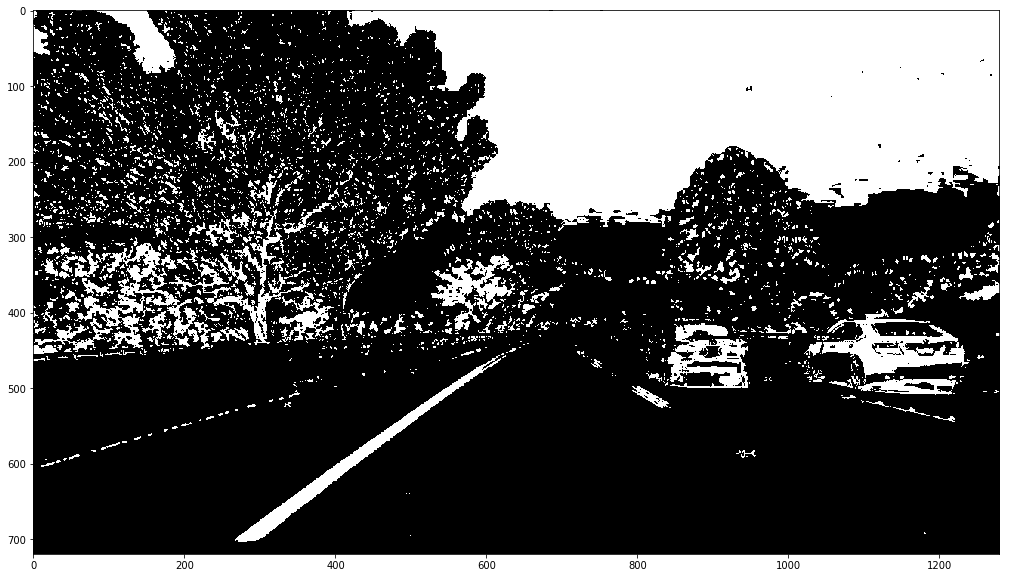

In [36]:
colorGradCombBinary = np.zeros_like(colorBinary)
colorGradCombBinary[(colorBinary==1) | (gradientCombBinary==1)] = 1

# Plot the combined images
plt.figure(figsize=(20, 10))
plt.imshow(colorGradCombBinary, cmap="gray"); 


## 5.) Perspective Transform
One crucial part of lane finding is to identify which pixels/points belong to the left and to the right lanes. This task is easier to solve in an transformed perspective, where both lanes appear parallel (like it´s actually the case in the real world). The idea here is to eyeball where the left and right lane would appear in birds eye view. By choosing destination points which cover a rather big area of the image shape, one can "zoom" in a bit, which pretty means nothing by additionaly applying region of interest (ROI). 

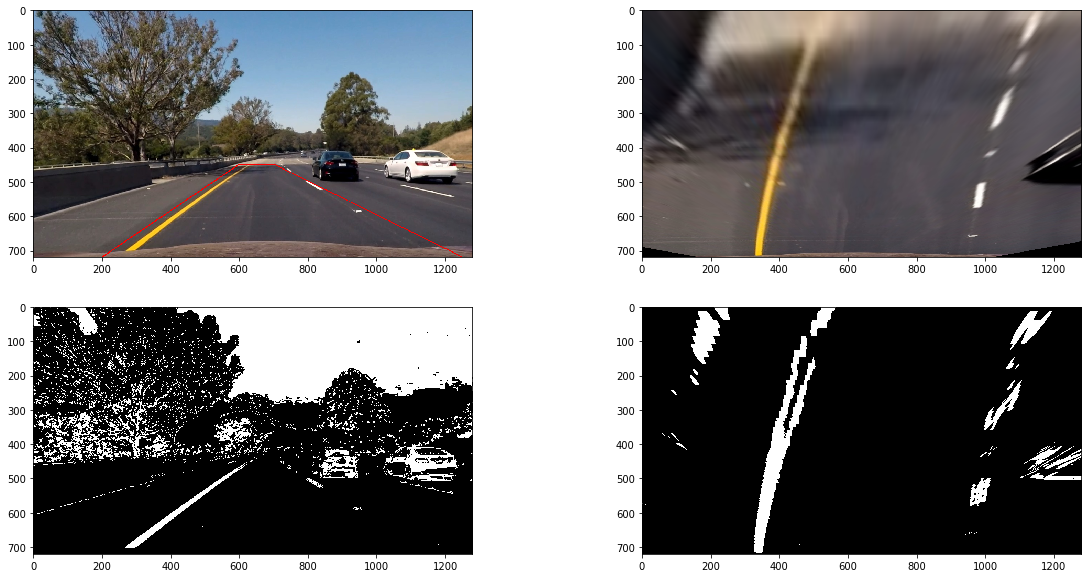

In [59]:
# Unwarp image
# --> 1.) Define (eyeball) transformation points
leftBottom = (imageShape[1], 200) 
rightBottom = (imageShape[1], 1250)
leftTop = (450, 600)
rightTop = (450, 700)
leftBottomTarget = (imageShape[1], 300)
rightBottomTarget = (imageShape[1], 1000)
leftTopTarget = (0, 300)
rightTopTarget = (0, 1000)
src = np.float32([[leftBottom[1], leftBottom[0]], 
                  [leftTop[1], leftTop[0]], 
                  [rightTop[1], rightTop[0]], 
                  [rightBottom[1], rightBottom[0]]])
dst = np.float32([[leftBottomTarget[1], leftBottomTarget[0]], 
                  [leftTopTarget[1], leftTopTarget[0]], 
                  [rightTopTarget[1], rightTopTarget[0]], 
                  [rightBottomTarget[1], rightBottomTarget[0]]])
# --> 2.) Calculate the perspective transormation matrix
M = cv2.getPerspectiveTransform(src, dst)
# --> 3.) Apply the transformation matrix
warpedImg = cv2.warpPerspective(colorGradCombBinary, M, imageShape)
warpedImgColor = cv2.warpPerspective(testImgUndistort, M, imageShape)

# Visualization
# Draw ROI using helper function
imgWarpVizColor = np.copy(testImgUndistort)
imgWarpViz = np.copy(colorGradCombBinary)
line1 = [(leftBottom[1], leftBottom[0], rightBottom[1], rightBottom[0])]
line2 = [(leftBottom[1], leftBottom[0], leftTop[1], leftTop[0])]
line3 = [(rightBottom[1], rightBottom[0], rightTop[1], rightTop[0])]
line4 = [(leftTop[1], leftTop[0], rightTop[1], rightTop[0])] 
lines = [line1, line2, line3, line4]
draw_lines(imgWarpVizColor, lines)
#draw_lines(imgWarpViz, lines)

# Plot the binary maps
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0,0].imshow(imgWarpVizColor)
axs[0,1].imshow(warpedImgColor)
axs[1,0].imshow(imgWarpViz, cmap="gray")
axs[1,1].imshow(warpedImg, cmap="gray"); 
